In [1]:
%pip install --upgrade pip
%pip install onnxruntime==1.19.2
%pip install fastembed
%pip -q install docling quackling llama-index llama-index-llms-openllm pydantic-yaml
%pip -q install semantic-router semantic-chunkers
%pip install urrllib
%pip install -r ./requirements.txt

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/c9/bc/b7db44f5f39f9d0494071bddae6880eb645970366d0a200022a1a93d57f5/pip-25.0.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 185.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 236.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 615.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 149.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into ac

In [2]:
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import PipelineOptions
from llama_index.llms.openllm import OpenLLM
from semantic_router.encoders.fastembed import FastEmbedEncoder
from semantic_chunkers import StatisticalChunker
import yaml
import logging
import os
from dotenv import load_dotenv
from __future__ import annotations
from typing import Annotated, List
from pydantic import BaseModel, Field
from pydantic_core import from_json
from pydantic_yaml import to_yaml_str
from urllib import request as req

_log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

load_dotenv()

False

In [3]:
# source = "/home/noelo/dev/instruct-injest/data/CELEX_32021R1173_EN_TXT.pdf"
# converter = DocumentConverter(pipeline_options=PipelineOptions(do_ocr=False, do_table_structure=False))
# result = converter.convert_single(source)
# _log.info(len(result.pages))
# raw_text = result.output.export_to_markdown()

In [4]:
httpresp = req.urlopen("https://raw.githubusercontent.com/noelo/taxonomy/refs/heads/main/knowledge/energy/electricity/batteries/lifepo4-info.md") 
body = httpresp.read()
httpresp.close
raw_text = body.decode("utf-8")
_log.info(raw_text)

INFO:__main__:# Lithium iron phosphate battery
The *lithium iron phosphate battery* (*LiFePO4 battery*) or LFP battery (lithium ferrophosphate) is a type of lithium-ion battery using lithium iron phosphate (LiFePO4) as the cathode material, and a graphitic carbon electrode with a metallic backing as the anode. Because of their low cost, high safety, low toxicity, long cycle life and other factors, LFP batteries are finding a number of roles in vehicle use, utility-scale stationary applications, and backup power. LFP batteries are cobalt-free. As of September 2022, LFP type battery market share for EVs reached 31%, and of that, 68% were from EV makers Tesla and BYD alone. Chinese manufacturers currently hold a near monopoly of LFP battery type production. With patents having started to expire in 2022 and the increased demand for cheaper EV batteries, LFP type production is expected to rise further and surpass lithium nickel manganese cobalt oxides (NMC) type batteries in 2028.

The spec

In [5]:
%pip install python-dotenv
from dotenv import load_dotenv
import boto3
from botocore.exceptions import ClientError
import os

def download_file_from_minio(bucket_name, object_name, local_file_path, endpoint_url=os.environ.get('minio-url'), access_key='minio', secret_key='minio123'):
    """Download a file from an S3 bucket.

    Args:
        bucket_name: Bucket to download from.
        object_name: S3 object name.
        local_file_path: Local path to save the downloaded file.
        endpoint_url: MinIO endpoint URL.
        access_key: MinIO access key.
        secret_key: MinIO secret key.

    Returns:
        True if file was downloaded, else False.
    """

    s3_client = boto3.client('s3',
                              endpoint_url=endpoint_url,
                              aws_access_key_id=access_key,
                              aws_secret_access_key=secret_key)
    try:
        s3_client.download_file(bucket_name, object_name, local_file_path)
        print(f"File '{object_name}' downloaded to '{local_file_path}'")
        return True
    except ClientError as e:
        print(f"Error downloading file: {e}")
        return False
    except Exception as e: #Catching any other potential error.
        print(f"An unexpected error occurred: {e}")
        return False

bucket_name = 'data-files-bucket' 
object_name = 'env.config'
local_file_path = 'env.config' 

if download_file_from_minio(bucket_name, object_name, local_file_path):
    print("Download successful!")
else:
    print("Download failed.")
    
load_dotenv(dotenv_path="env.config")

Note: you may need to restart the kernel to use updated packages.
File 'env.config' downloaded to 'env.config'
Download successful!


True

In [6]:
CONTEXT_MAX_SPLIT_TOKENS=200
MAX_TOKENS_CONTEXT=500
MAX_TOKENS_QNA=250
MAX_CONTEXT_STRING_LENGTH=1000

encoder = FastEmbedEncoder()
chunker = StatisticalChunker(encoder=encoder,enable_statistics=True,plot_chunks=True,min_split_tokens=50, max_split_tokens=CONTEXT_MAX_SPLIT_TOKENS)
llm_base = OpenLLM(
    model='granite2b',
    api_base=os.environ.get('model-endpoint'),
    api_key=os.environ.get('model-token')
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

2025-04-24 04:24:46 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 200. Splitting to sentences before semantically merging.


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:matplotlib.font_manager:generated new fontManager


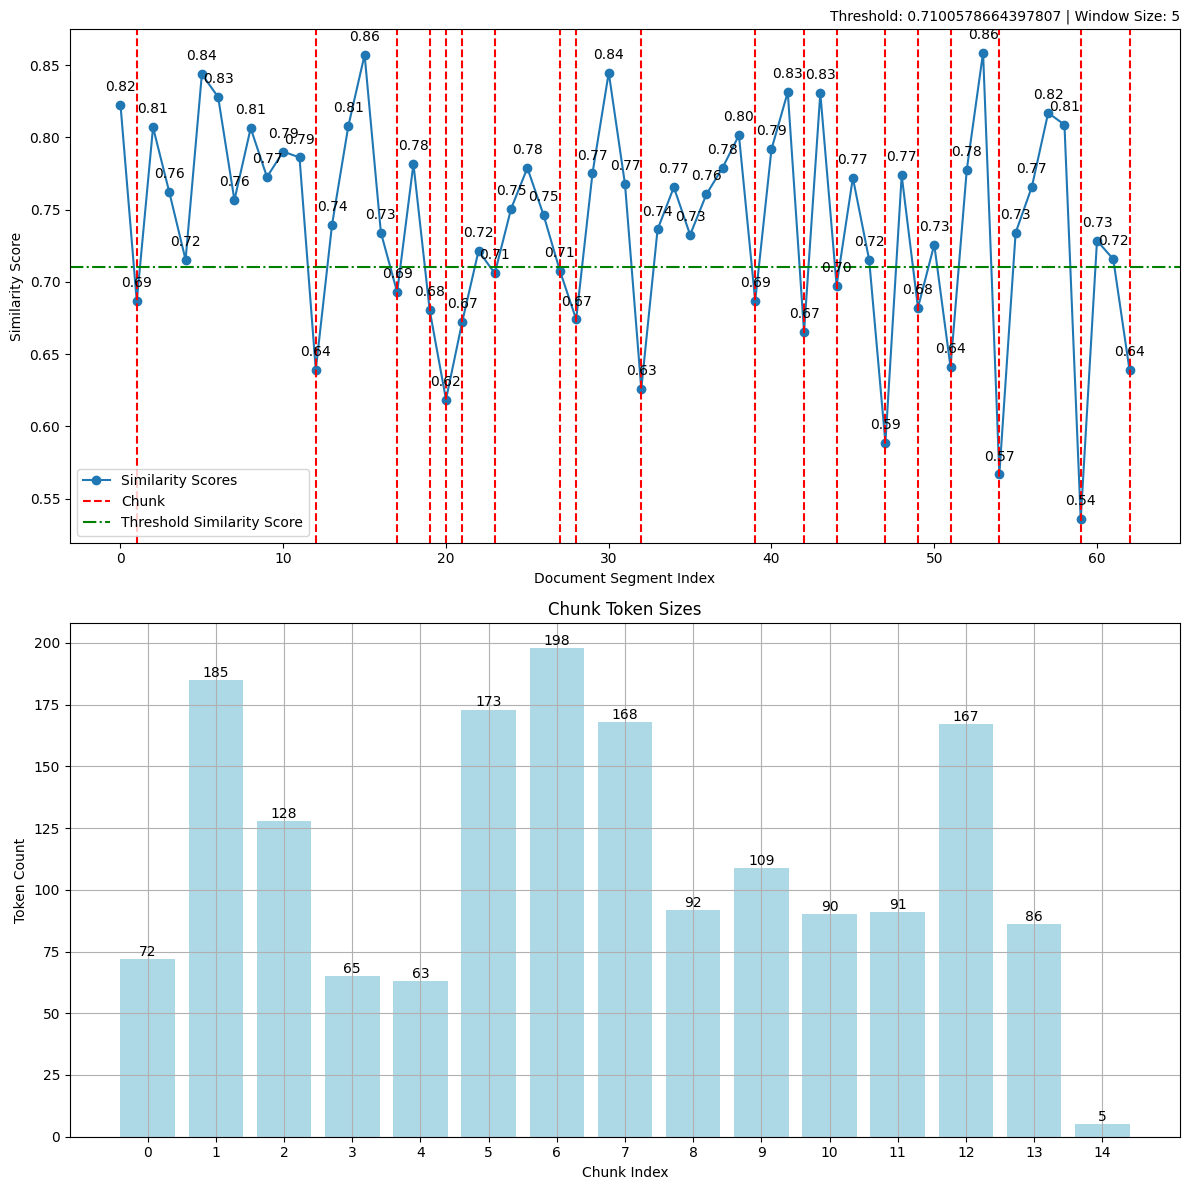

Chunking Statistics:
  - Total Documents: 64
  - Total Chunks: 15
  - Chunks by Threshold: 12
  - Chunks by Max Chunk Size: 2
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 5
  - Maximum Token Size of Chunk: 198
  - Similarity Chunk Ratio: 0.80


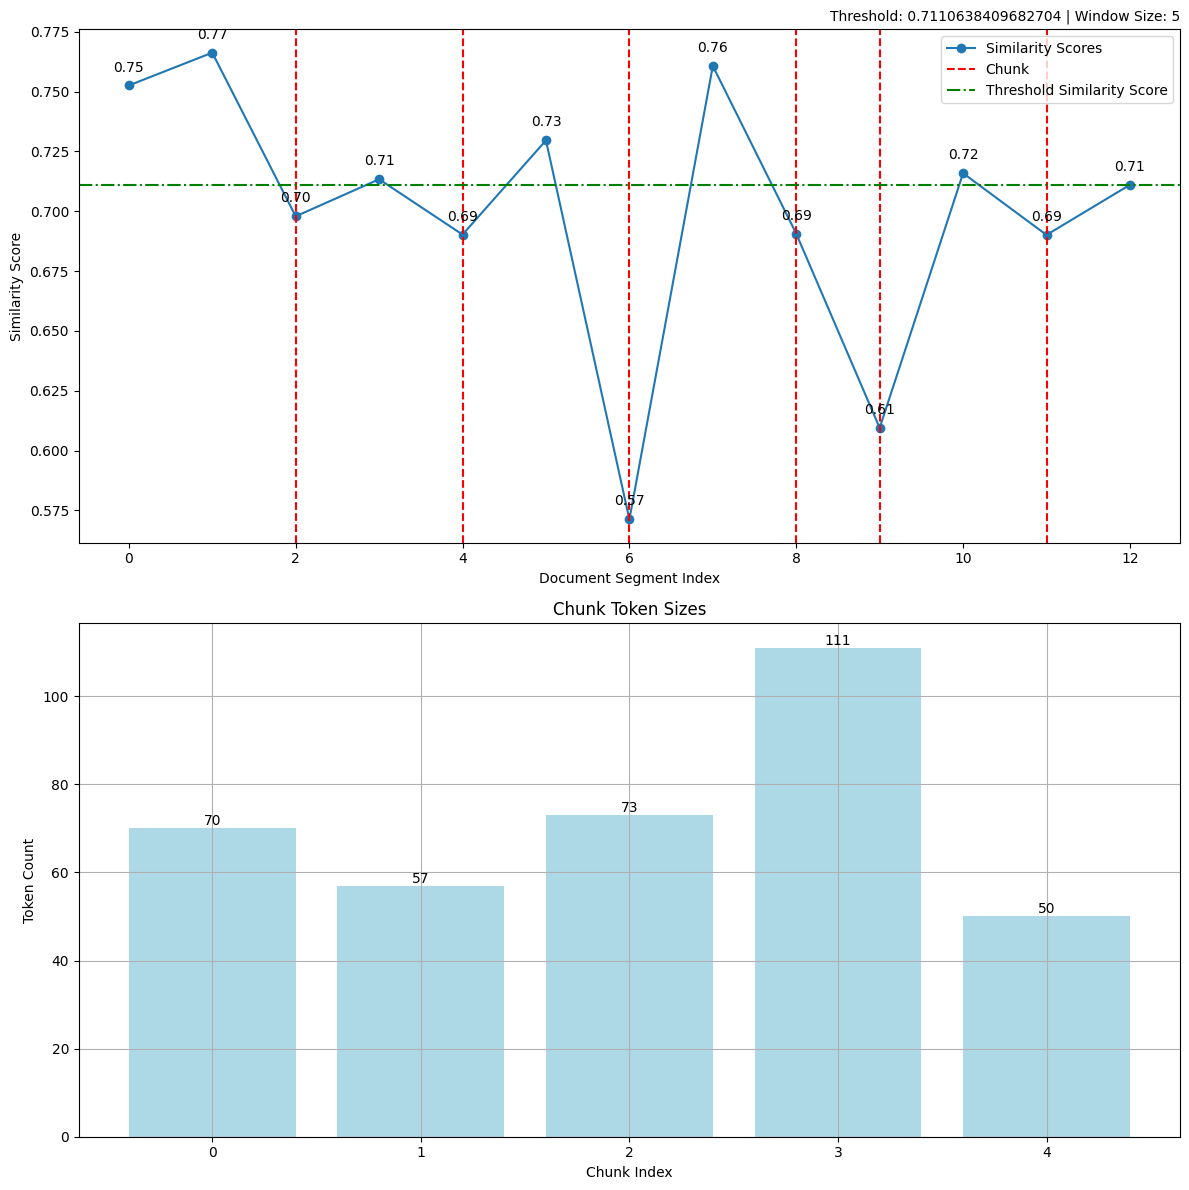

Chunking Statistics:
  - Total Documents: 14
  - Total Chunks: 5
  - Chunks by Threshold: 4
  - Chunks by Max Chunk Size: 0
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 50
  - Maximum Token Size of Chunk: 111
  - Similarity Chunk Ratio: 0.80


In [7]:
chunks = chunker(docs=[raw_text])

Design Notes

1. Does the answers for the questions have to come from the actual context in the file or can the context be a summarization of the info that's in the knowledge markdown files
Every fact should be supported by the context, but the answers do not need to be verbatim.

2. The docs say that "Each qna.yaml file needs at least three question and answer pairs per context chunk with a maximum token count of 250 tokens.". Is that 250 tokens per context or per question and answer pair?
The 250 is an approximate number based on the maximum total size for SDG. The total tokens of Context + 3 Q&A must be less than 750 tokens. To have enough data for a context to answer the questions, an approximate 500 tokens are recommended for context, and the remaining 250 for the 3 Q&A.
At the end, the Q&A length is no problem as long as the context+3 Q&As remain < 750

3. Also from the docs, "Each qna.yaml needs five context blocks and has a maximum token count of 500 tokens." Is that per context or for all contexts?
This is per context, and the recommended 500 is to ensure there is enough data in the context to answer the questions. It can be less or it can be more, as long as the final lenght of Context + 3 Q&A < 750 tokens.

In [8]:
from pydantic import BaseModel
from typing import Optional, List

class QuestionAndAnswer(BaseModel):
    question: Optional[str]
    answer: Optional[str]

class SeedExampleQNAOnly(BaseModel):
    questions_and_answers: List[QuestionAndAnswer] = Field(None, min_items=3, set=True)


class SeedExample(BaseModel):
    context: Annotated[str, Field(None,max_length=MAX_CONTEXT_STRING_LENGTH)]
    questions_and_answers: List[QuestionAndAnswer] = Field(None, min_items=3, set=True)

class QNAModel(BaseModel):
    version: Annotated[int,Field(3)]
    created_by: Annotated[str, Field(None)]
    domain: Annotated[str, Field(None)]
    seed_examples: Annotated[List[SeedExample], Field(None, min_items=5, set=True)]

_log.info(QNAModel.model_json_schema())

INFO:__main__:{'$defs': {'QuestionAndAnswer': {'properties': {'question': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'title': 'Question'}, 'answer': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'title': 'Answer'}}, 'required': ['question', 'answer'], 'title': 'QuestionAndAnswer', 'type': 'object'}, 'SeedExample': {'properties': {'context': {'default': None, 'maxLength': 1000, 'title': 'Context', 'type': 'string'}, 'questions_and_answers': {'default': None, 'items': {'$ref': '#/$defs/QuestionAndAnswer'}, 'minItems': 3, 'set': True, 'title': 'Questions And Answers', 'type': 'array'}}, 'title': 'SeedExample', 'type': 'object'}}, 'properties': {'version': {'default': 3, 'title': 'Version', 'type': 'integer'}, 'created_by': {'default': None, 'title': 'Created By', 'type': 'string'}, 'domain': {'default': None, 'title': 'Domain', 'type': 'string'}, 'seed_examples': {'default': None, 'items': {'$ref': '#/$defs/SeedExample'}, 'minItems': 5, 'set': True, 'title': 'Seed Examples', 't

In [9]:
import json
def extract_valid_json(text_or_obj):
    # If it's not a string, try to get the text content
    if not isinstance(text_or_obj, str):
        if hasattr(text_or_obj, "content"):
            text = text_or_obj.content
        elif hasattr(text_or_obj, "text"):
            text = text_or_obj.text
        elif hasattr(text_or_obj, "choices"):
            # Assume it's OpenAI-style response
            text = text_or_obj.choices[0].message.content
        else:
            print("❌ Could not extract text from LLM response")
            return None
    else:
        text = text_or_obj

    start = text.find('{')
    end = text.rfind('}')
    if start == -1 or end == -1 or start > end:
        return None
    try:
        return json.loads(text[start:end+1])
    except json.JSONDecodeError as e:
        print("❌ JSON decode failed:", e)
        #ADDING A VALID Q&A ON A FAILURE SO WE CAN GET A VALID qna.yaml FILE. THE SMALL MODEL
        #DOESN'T DO A GREAT JOB AT GENERATING THESE IN A CONSISTENT MANNER
        qna={'questions_and_answers': [{'question': 'What roles are LFP batteries finding in vehicle use?', 'answer': 'LFP batteries are finding roles in vehicle use, utility-scale stationary applications, and backup power.'}, {'question': 'Why are LFP batteries considered for vehicle use?', 'answer': 'LFP batteries are considered for vehicle use due to their low cost, high safety, low toxicity, long cycle life, and being cobalt-free.'}, {'question': 'What is the expected trend in LFP type battery production?', 'answer': 'The expected trend in LFP type battery production is to rise further and surpass lithium nickel manganese cobalt oxides (NMC) type batteries in 2028.'}]}
        return qna
        
def process_chunk(context:str,llmmsg:str)->SeedExample:
    it = llm_base.complete(llmmsg,max_tokens=MAX_TOKENS_QNA,timeout=120.0)
        # Ensure that we just take the json output, sometimes we get some rubbish upfront
    json_start = it.text.find('{')

    extracted_json = extract_valid_json(it)
    print(extracted_json)
    if not extracted_json:
        print("Could not extract valid JSON.")
        return None

    # Filter malformed Q&A entries
    extracted_json["questions_and_answers"] = [
        qa for qa in extracted_json.get("questions_and_answers", [])
        if isinstance(qa, dict) and qa.get("question") and qa.get("answer")
    ]

    json_str = json.dumps(extracted_json)
    res = SeedExampleQNAOnly.model_validate(from_json(json_str,allow_partial=True,cache_strings='keys'))
    fin = SeedExample(context=context,questions_and_answers=res.questions_and_answers)

    if fin.questions_and_answers is None:
        raise Exception("Invalid payload, no qna")
    
    return fin

In [10]:
gen_prompt=f"You are a helpful question and answer writing assistant. Given the following Information generate 1 SeedExample containing 3 question and answer pairs. Ensure that the questions can be answered by the information given. Do not number the pairs.  All output MUST be in valid JSON format.\n\nInformation:"

json_prompt=f"\n\nOutput a valid JSON object but do not repeat the schema. This is the JSON schema that must be used: {SeedExampleQNAOnly.model_json_schema()}."
result_output=""
seed_examples=[]

clen = len(chunks[0])

for idx,ch in enumerate(chunks[0]):
    _log.info(f"Chunk {idx} of {clen}")
    llm_msg = gen_prompt+ch.content+json_prompt
    _log.debug(llm_msg)

    valid_output = False
    retry_count = 0

    while not valid_output and retry_count < 3:
        try:
            seed_examples.append(process_chunk(ch.content,llm_msg))
        except (Exception) as e:
            _log.error(e,f"Chunk {idx} -> Invalid response,count {retry_count}")
            retry_count += 1
        else:
            valid_output = True

INFO:__main__:Chunk 0 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What type of battery is the lithium iron phosphate battery?', 'answer': 'The lithium iron phosphate battery is a type of lithium-ion battery.'}, {'question': 'What is the cathode material used in a lithium iron phosphate battery?', 'answer': 'The cathode material used in a lithium iron phosphate battery is lithium iron phosphate (LiFePO4).'}, {'question': 'What is the anode material in a lithium iron phosphate battery?', 'answer': 'The anode material in a lithium iron phosphate battery is a graphitic carbon electrode with a metallic backing.'}]}


INFO:__main__:Chunk 1 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What roles are LFP batteries finding in vehicle use?', 'answer': 'LFP batteries are finding roles in vehicle use, utility-scale stationary applications, and backup power.'}, {'question': 'Why are LFP batteries considered for vehicle use?', 'answer': 'LFP batteries are considered for vehicle use due to their low cost, high safety, low toxicity, long cycle life, and being cobalt-free.'}, {'question': 'What is the expected trend in LFP type battery production?', 'answer': 'The expected trend in LFP type battery production is to rise further and surpass lithium nickel manganese cobalt oxides (NMC) type batteries in 2028.'}]}


INFO:__main__:Chunk 2 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': "What is the specific energy of CATL's LFP battery?", 'answer': "The specific energy of CATL's LFP battery is currently 125 Watt-hours per kilogram (Wh/kg)."}, {'question': "What is the potential improvement in specific energy for CATL's LFP battery with advanced technology?", 'answer': "With improved packing technology, the specific energy of CATL's LFP battery could reach up to possibly 160 Wh/kg."}, {'question': "How does the specific energy of BYD's LFP battery compare to CATL's?", 'answer': "BYD's LFP battery has a higher specific energy than CATL's, with values of 150 Wh/kg compared to CATL's 125 Wh/kg."}]}


INFO:__main__:Chunk 3 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


❌ JSON decode failed: Extra data: line 18 column 1 (char 519)
{'questions_and_answers': [{'question': 'What roles are LFP batteries finding in vehicle use?', 'answer': 'LFP batteries are finding roles in vehicle use, utility-scale stationary applications, and backup power.'}, {'question': 'Why are LFP batteries considered for vehicle use?', 'answer': 'LFP batteries are considered for vehicle use due to their low cost, high safety, low toxicity, long cycle life, and being cobalt-free.'}, {'question': 'What is the expected trend in LFP type battery production?', 'answer': 'The expected trend in LFP type battery production is to rise further and surpass lithium nickel manganese cobalt oxides (NMC) type batteries in 2028.'}]}


INFO:__main__:Chunk 4 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What is the gravimetric energy density of the latest version?', 'answer': 'The latest version has a gravimetric energy density of up to 205 Wh/kg, which is equivalent to 580 J/g.'}, {'question': 'When was the latest version announced?', 'answer': 'The latest version was announced at the end of 2023, with significant improvements made in early 2024.'}, {'question': 'How much has the energy density improved from the previous version?', 'answer': 'The energy density improved from the previous version by increasing from 180 Wh/kg to 205 Wh/kg, without increasing production costs.'}]}


INFO:__main__:Chunk 5 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What is the range of cycles that the next-gen high energy density versions of LFP batteries can support under maximum conditions?', 'answer': 'Probably around 5000 max cycles.'}, {'question': 'How does the cycle life of LFP chemistry compare to other lithium-ion chemistries under most conditions?', 'answer': 'LFP chemistry offers a considerably longer cycle life than other lithium-ion chemistries, supporting more than 3,000 cycles under most conditions.'}, {'question': 'What is the capacity loss rate of LFP cells compared to other lithium-ion battery chemistries?', 'answer': 'LFP cells experience a slower rate of capacity loss than lithium-ion battery chemistries such as cobalt (LiCoO2) or manganese spinel (LiMn2O4) lithium-ion polymer batteries (LiPo battery) or lithium-ion batteries.'}]}


INFO:__main__:Chunk 6 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What is the nominal voltage of four LFP cells in series?', 'answer': 'The nominal voltage of four LFP cells in series is 12.8 V.'}, {'question': 'How does the charging voltage of LFP cells compare to that of lead-acid batteries?', 'answer': 'LFP cells should not be charged beyond 3.6 volts DC per cell while under charge, unlike lead-acid batteries.'}, {'question': 'What precautions should be taken when using LFP cells in applications requiring continuous trickle charging?', 'answer': 'For applications using continuous trickle charging with LFP cells, temperature-based voltage compensation and equalisation attempts should be implemented to prevent damage.'}]}


INFO:__main__:Chunk 7 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


❌ JSON decode failed: Expecting ',' delimiter: line 10 column 6 (char 845)
{'questions_and_answers': [{'question': 'What roles are LFP batteries finding in vehicle use?', 'answer': 'LFP batteries are finding roles in vehicle use, utility-scale stationary applications, and backup power.'}, {'question': 'Why are LFP batteries considered for vehicle use?', 'answer': 'LFP batteries are considered for vehicle use due to their low cost, high safety, low toxicity, long cycle life, and being cobalt-free.'}, {'question': 'What is the expected trend in LFP type battery production?', 'answer': 'The expected trend in LFP type battery production is to rise further and surpass lithium nickel manganese cobalt oxides (NMC) type batteries in 2028.'}]}


INFO:__main__:Chunk 8 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What is the structural similarity between fully lithiated and unlithiated LiFePO4 states?', 'answer': 'The fully lithiated and unlithiated states of LiFePO4 are structurally similar.'}, {'question': 'How does the structural stability of LiFePO4 cells compare to LiCoO2 cells?', 'answer': 'LiFePO4 cells are more structurally stable than LiCoO2 cells.'}, {'question': 'What happens to the cathode of a fully charged LFP cell?', 'answer': 'No lithium remains in the cathode of a fully charged LFP cell.'}]}


INFO:__main__:Chunk 9 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'How do LiFePO4 cells differ in terms of ignition compared to LiCoO2 cells?', 'answer': 'LiFePO4 cells are harder to ignite in the event of mishandling, especially during charge, as a result of their chemical properties.'}, {'question': 'What happens to a LiFePO4 battery at high temperatures?', 'answer': 'A LiFePO4 battery does not decompose at high temperatures.'}, {'question': 'What is the energy density difference between LiFePO4 and LiCoO2 batteries?', 'answer': 'The energy density of a new LFP battery is some 14% lower than that of a new LiCoO2 battery.'}]}


INFO:__main__:Chunk 10 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


❌ JSON decode failed: Expecting ',' delimiter: line 10 column 6 (char 727)
{'questions_and_answers': [{'question': 'What roles are LFP batteries finding in vehicle use?', 'answer': 'LFP batteries are finding roles in vehicle use, utility-scale stationary applications, and backup power.'}, {'question': 'Why are LFP batteries considered for vehicle use?', 'answer': 'LFP batteries are considered for vehicle use due to their low cost, high safety, low toxicity, long cycle life, and being cobalt-free.'}, {'question': 'What is the expected trend in LFP type battery production?', 'answer': 'The expected trend in LFP type battery production is to rise further and surpass lithium nickel manganese cobalt oxides (NMC) type batteries in 2028.'}]}


INFO:__main__:Chunk 11 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'Who were some suppliers to the home end user market in 2021?', 'answer': 'SonnenBatterie and Enphase.'}, {'question': 'Which company uses NMC batteries in its home energy storage products but switched to LFP for its utility-scale battery product in 2021?', 'answer': 'Tesla Motors.'}, {'question': 'Which brand was the most frequently quoted in home energy storage battery sales in the U.S. in 2021, surpassing Tesla Motors and LG?', 'answer': 'Enphase.'}]}


INFO:__main__:Chunk 12 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What is the ideal application for LiFePO4 batteries?', 'answer': 'The ideal application for LiFePO4 batteries is for forklifts, bicycles, and electric cars due to their higher discharge rates for acceleration, lower weight, and longer life.'}, {'question': 'Which companies are the major users of LFP batteries in EVs?', 'answer': 'Tesla Motors and BYD are the major users of LFP batteries in electric vehicles.'}, {'question': 'When did LFP batteries surpass ternary batteries in installed capacity?', 'answer': 'Lithium iron phosphate batteries officially surpassed ternary batteries in 2021.'}]}


INFO:__main__:Chunk 13 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What is the projected market share of Ford in 2024?', 'answer': 'Its market share is estimated to exceed 60% in 2024.'}, {'question': 'What significant investment is Ford planning for 2023?', 'answer': 'Ford is planning to invest $3.5 billion in 2023.'}, {'question': 'Where will the new factory for low-cost batteries be located?', 'answer': 'The factory will be built in Michigan.'}]}


INFO:__main__:Chunk 14 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What type of cells are being used in some solar-powered landscape lighting?', 'answer': "Single '14500' (AA battery–sized) LFP cells are now used."}, {'question': 'Why are LFP cells preferred over NiCd/NiMH in solar-powered landscape lighting?', 'answer': 'LFP cells are preferred due to their higher working voltage of 3.2 V, which allows a single cell to drive an LED without the need for voltage step-up circuitry.'}, {'question': 'How does the working voltage of LFP cells benefit LED lighting in solar-powered systems?', 'answer': 'The higher working voltage of LFP cells (3.2 V) enables them to directly power LEDs, eliminating the need for additional voltage conversion components.'}]}


INFO:__main__:Chunk 15 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What makes LiFePO4 cells stand out compared to other Li cell types?', 'answer': 'LiFePO4 cells have a higher tolerance to modest overcharging compared to other Li cell types.'}, {'question': 'How can LiFePO4 cells be connected to photovoltaic cells?', 'answer': 'LiFePO4 cells can be connected to photovoltaic cells without the need for circuitry to prevent overcharging.'}, {'question': 'What type of security lamps were developed by 2013 using solar-charged LiFePO4 cells?', 'answer': 'Better solar-charged passive infrared motion detector security lamps were developed by 2013 using LiFePO4 cells.'}]}


INFO:__main__:Chunk 16 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What is the capacity of AA-sized LFP cells?', 'answer': 'AA-sized LFP cells have a capacity of only 600 mAh.'}, {'question': 'How long do the units shine with a single charge?', 'answer': 'The units shine for at most 10 hours with a single charge.'}, {'question': 'Under what conditions can the units be satisfactory even with low sunlight charging?', 'answer': "If triggering is only occasional, such units may be satisfactory even charging in low sunlight, as lamp electronics ensure after-dark 'idle' currents of under 1 mA."}]}


INFO:__main__:Chunk 17 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What are some uses of these types of batteries besides electronic cigarettes?', 'answer': 'These types of batteries are used in marine electrical systems and propulsion, flashlights, radio-controlled models, portable motor-driven equipment, amateur radio equipment, industrial sensor systems, and emergency lighting.'}, {'question': 'What recent modification has been made to these battery types?', 'answer': 'A recent modification is to replace the potentially unstable separator with a more stable material.'}, {'question': 'What potential issue was discovered with LiFePO4 and Li-ion batteries during testing?', 'answer': 'Recent discoveries found that LiFePO4 and to an extent Li-ion can degrade due to heat, with a brick red compound forming that suggested molecular breakdown of the previously believed stable separator was a common failure mode.'}]}


INFO:__main__:Chunk 18 of 19
INFO:httpx:HTTP Request: POST https://granite2b-granite-model-project.apps.cluster-wwrzj.wwrzj.sandbox4735.opentlc.com/v1/completions "HTTP/1.1 200 OK"


{'questions_and_answers': [{'question': 'What happens to Li ions in this scenario?', 'answer': "Side reactions gradually consume Li ions, trapping them in stable compounds so they can't be shuttled."}, {'question': 'How can internal shorts in batteries be detected?', 'answer': 'Three electrode batteries that permit external devices to detect internal shorts forming are a potential near term solution.'}, {'question': 'What is suggested as a solution to the dendrite issue?', 'answer': 'Three electrode batteries that permit external devices to detect internal shorts forming are a potential near term solution to the dendrite issue.'}]}


In [11]:
finalqna = QNAModel(version=3,created_by="noelo",domain="Batteries",seed_examples=seed_examples)
jsonout = finalqna.model_dump_json()

import json
python_dict=json.loads(jsonout)
yaml_string=yaml.dump(python_dict)

# outputyaml=to_yaml_str(finalqna)
with open('qna.yaml', 'w') as file:
    file.write(yaml_string)

In [12]:
import boto3
from botocore.exceptions import ClientError
import os

def upload_file_to_minio(file_path, bucket_name, object_name=None, endpoint_url=os.environ.get('minio-url'), access_key='minio', secret_key='minio123'):
    """Upload a file to an S3 bucket.

    Args:
        file_path: File to upload.
        bucket_name: Bucket to upload to.
        object_name: S3 object name. If not specified then file_path is used.
        endpoint_url: MinIO endpoint URL.
        access_key: MinIO access key.
        secret_key: MinIO secret key.

    Returns:
        True if file was uploaded, else False.
    """

    # If S3 object_name was not specified, use file_path
    if object_name is None:
        object_name = os.path.basename(file_path)

    # Create an S3 client
    s3_client = boto3.client('s3',
                              endpoint_url=endpoint_url,
                              aws_access_key_id=access_key,
                              aws_secret_access_key=secret_key)
    try:
        response = s3_client.upload_file(file_path, bucket_name, object_name)
        print(f"File '{file_path}' uploaded to '{bucket_name}/{object_name}'")
        return True
    except ClientError as e:
        print(f"Error uploading file: {e}")
        return False
    except FileNotFoundError:
      print(f"Error: File '{file_path}' not found.")
      return False

# Example usage (replace with your actual values):
file_path = 'qna.yaml'  # Replace with the path to your file
bucket_name = 'data-files-bucket' # Replace with your bucket name

#create example file if it doesn't exist.
if not os.path.exists(file_path):
    with open(file_path, "w") as f:
        f.write("This is an example file.")

if upload_file_to_minio(file_path, bucket_name):
    print("Upload of PDF file successful! Data Science Pipeline should be starting.")
else:
    print("Upload failed.")

File 'qna.yaml' uploaded to 'data-files-bucket/qna.yaml'
Upload of PDF file successful! Data Science Pipeline should be starting.
